In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/AMPRA


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cloudpickle         2.2.1
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
fsspec              2023.1.0
h5py                3.6.0
harmonypy           NA
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
jinja2              3.1.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
markupsafe          2.1.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3


# Parameters

In [4]:
params = {
'harmony_vars' : ['donor'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 20,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 31,
'n_adt_pcs' : 19,
'name_addition' : '.ADT_20.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTf

In [6]:
! ls ../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.h5ad

../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.h5ad


# Run pipeline

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/anndata/_core/anndata.py:896: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_index(names, "var")
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


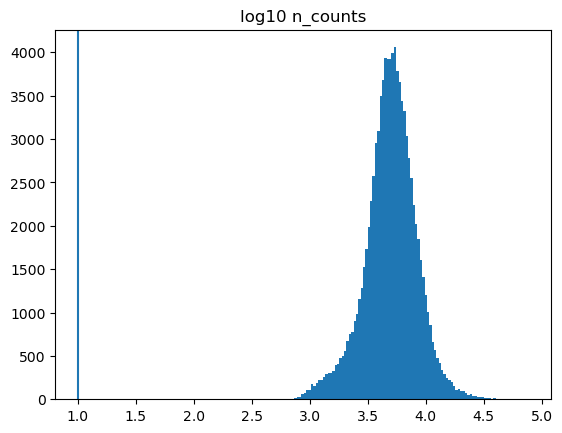

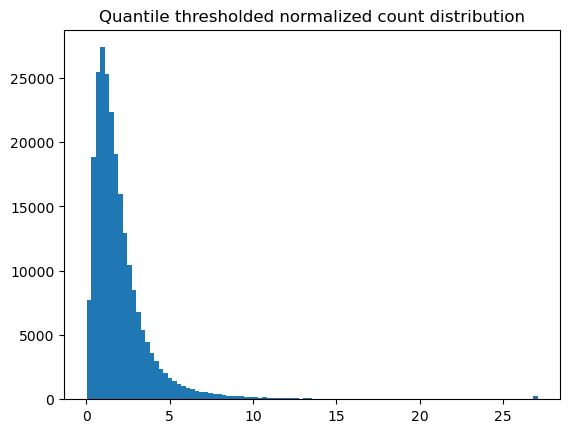

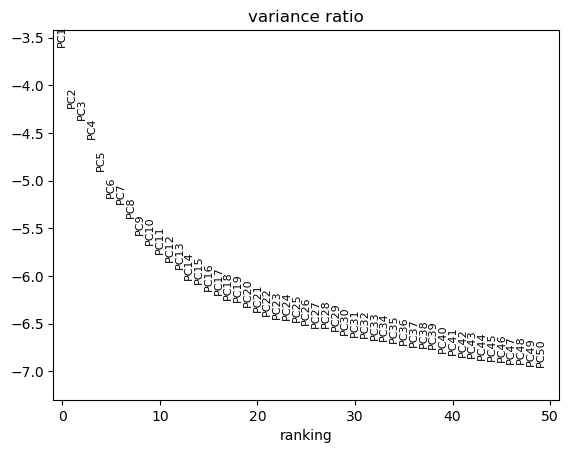

2023-08-03 21:23:02,113 - harmonypy - INFO - Iteration 1 of 20
2023-08-03 21:24:02,098 - harmonypy - INFO - Iteration 2 of 20
2023-08-03 21:25:03,098 - harmonypy - INFO - Iteration 3 of 20
2023-08-03 21:26:03,029 - harmonypy - INFO - Iteration 4 of 20
2023-08-03 21:27:09,896 - harmonypy - INFO - Iteration 5 of 20
2023-08-03 21:28:09,284 - harmonypy - INFO - Iteration 6 of 20
2023-08-03 21:28:44,560 - harmonypy - INFO - Iteration 7 of 20
2023-08-03 21:29:15,416 - harmonypy - INFO - Iteration 8 of 20
2023-08-03 21:29:41,961 - harmonypy - INFO - Iteration 9 of 20
2023-08-03 21:30:08,488 - harmonypy - INFO - Iteration 10 of 20
2023-08-03 21:30:35,075 - harmonypy - INFO - Iteration 11 of 20
2023-08-03 21:31:01,692 - harmonypy - INFO - Iteration 12 of 20
2023-08-03 21:31:28,259 - harmonypy - INFO - Converged after 12 iterations
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs

In [7]:
adata = sc.read(paths['Original'])

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [8]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [9]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


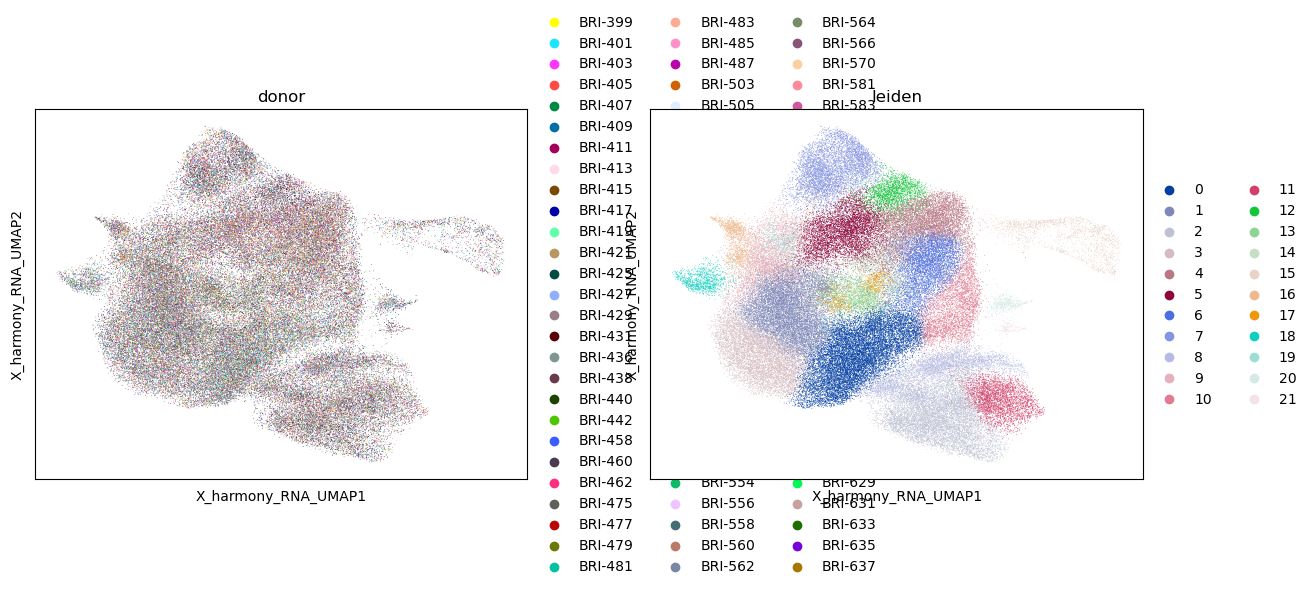

In [10]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [11]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [6]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [7]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((94048, 33596), (94048, 2000), (94048, 33596))

In [8]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.FiltForcNMF.h5ad'

In [9]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.FiltForcNMF', '.h5ad'].
Only considering the two last: ['.FiltForcNMF', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


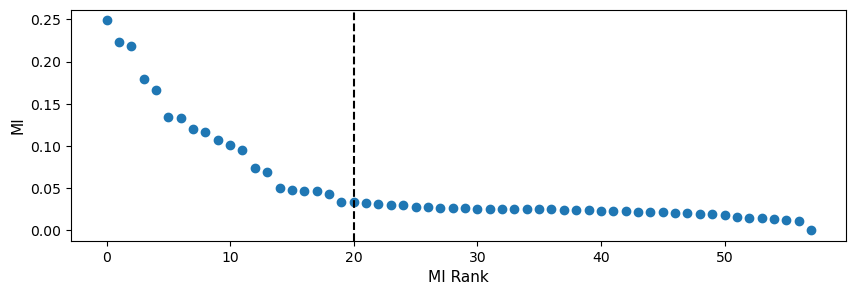

In [12]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [13]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


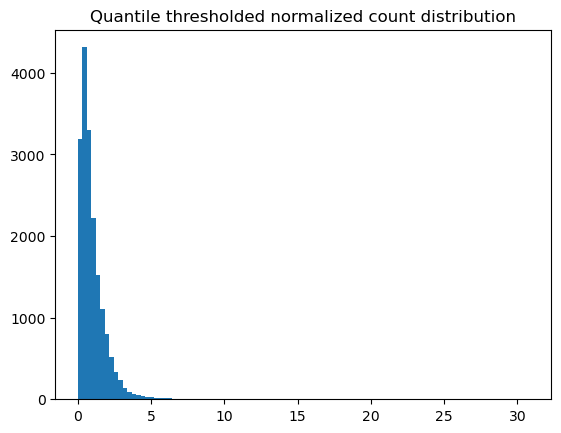

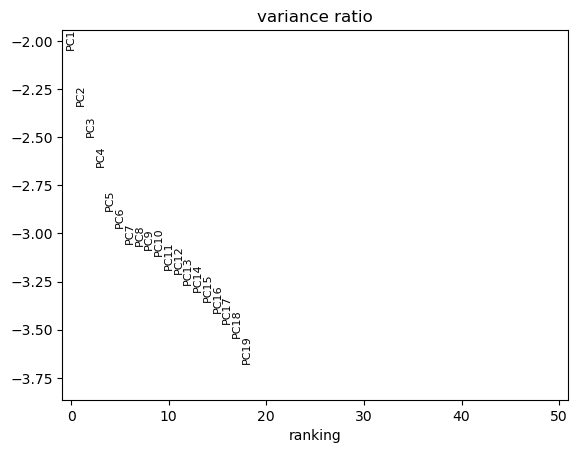

2023-08-03 21:40:55,574 - harmonypy - INFO - Iteration 1 of 20
2023-08-03 21:41:52,787 - harmonypy - INFO - Iteration 2 of 20
2023-08-03 21:42:48,526 - harmonypy - INFO - Iteration 3 of 20
2023-08-03 21:43:49,689 - harmonypy - INFO - Iteration 4 of 20
2023-08-03 21:44:35,210 - harmonypy - INFO - Iteration 5 of 20
2023-08-03 21:45:19,888 - harmonypy - INFO - Iteration 6 of 20
2023-08-03 21:45:55,938 - harmonypy - INFO - Converged after 6 iterations


In [14]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [17]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [18]:
adata_ADT_c

AnnData object with n_obs × n_vars = 94048 × 20
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample', 'cluster', 'cell_type', 'donor', 'fibro', 'Tfilter', 'nUMI', 'nGene', 'percent_mito', 'Tfilter2', 'cluster_number', 'cluster_name', 'UMAP1', 'UMAP2', 'n_counts'
    var: 'Original_Name', 'features', 'Name_ADT_Fixed', 'Gene_ADT_Fixed', 'Clone_ADT_Fixed', 'feature_types', 'features_renamed', 'mean', 'std', 'MI', 'MI_Rank', 'MI_diff', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony'
    obsp: 'distances', 'connectivities'

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


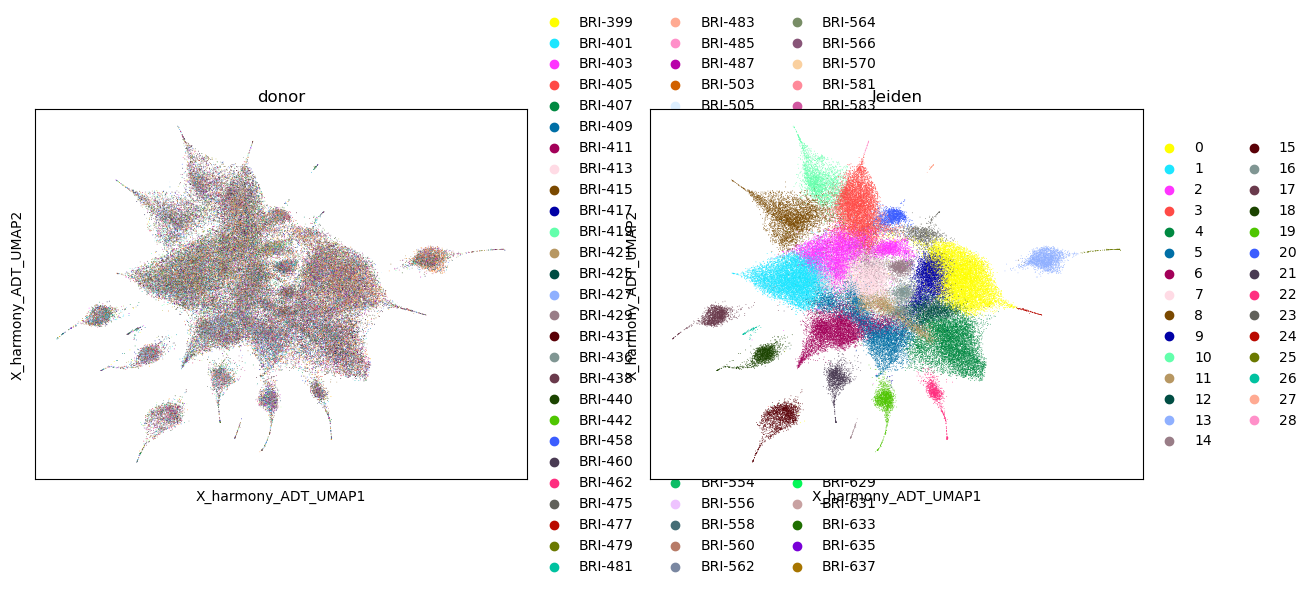

In [19]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [20]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:351: NumbaWarning: Cannot cache compiled function "process_candidates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  nn_descent_internal_low_memory_parallel(
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cann

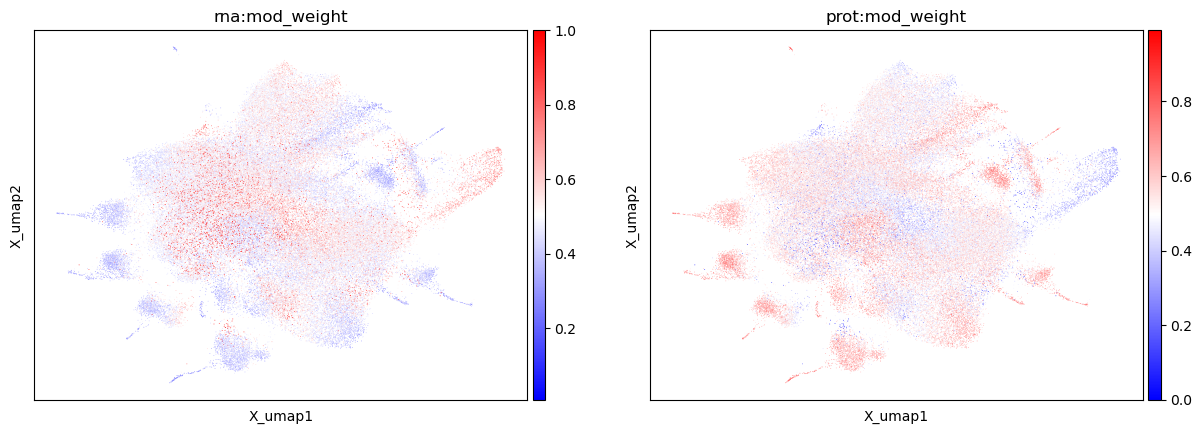

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


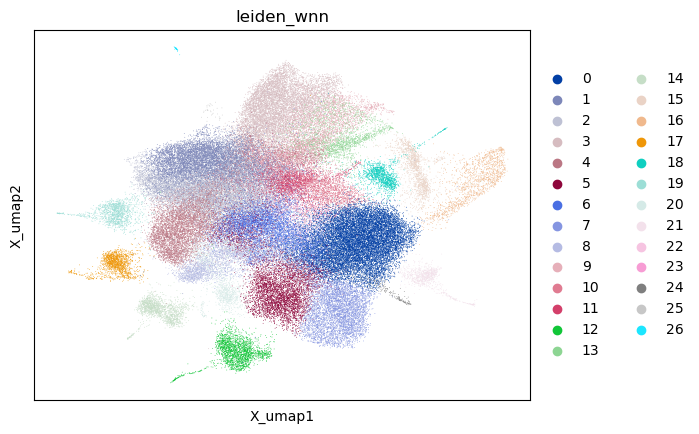

In [21]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [22]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [23]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.p

In [24]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

In [25]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,CCL5,GZMK,NKG7,CD8A,CST7,GZMA,CD8B,HLA-DPB1,CTSW,APOBEC3G,GZMH,HLA-DRB1,KLRG1,CD74,HLA-DPA1,MATK,EOMES,HLA-DQA2,CMC1,AOAH
1,JUNB,FOS,IL7R,TNFAIP3,TPT1,DUSP1,FOSB,FTH1,CD69,ANXA1,ZFP36,YPEL5,JUN,ZFP36L2,CXCR4,TSC22D3,EEF1A1,RPL36A,RPS12,KLF6
2,IL7R,LTB,RPL36A,TPT1,RPS12,RPS18,AQP3,NOSIP,RPS6,RPLP0,RPLP1,RPL17,MAL,CD40LG,RPS2,TRABD2A,DPP4,RPS8,TXNIP,MTRNR2L12
3,NR3C1,TSHZ2,MAF,FKBP5,RNF19A,PDCD1,CD4,LIMS1,SPOCK2,TNFRSF18,ZNRF1,RBPJ,PGM2L1,DRAIC,CORO1B,THADA,TOX2,TIGIT,IL6ST,TBC1D4
4,RPS8,RPS6,TPT1,SELL,RPS12,RPS18,MAL,LEF1,CCR7,EEF1A1,RPS26,SOCS3,JUNB,RPL36A,FHIT,RPS2,ADTRP,RTKN2,LTB,NPM1
5,NKG7,GZMH,FGFBP2,KLRD1,GNLY,PRF1,CCL5,PLEK,EFHD2,CST7,CX3CR1,CTSW,C1orf21,ADGRG1,KLRG1,ZEB2,TRGC2,FCGR3A,GZMB,HOPX
6,FN1,PRG4,COL3A1,COL1A2,HTRA1,CRTAC1,TIMP3,TNXB,MIAT,PLA2G2A,CST3,SPARCL1,DCN,CFD,CALD1,GSN,TTN,MGP,APOE,DST
7,NKG7,CCL5,CST7,KLRD1,CTSW,TRGC2,KLRG1,CMC1,GZMH,GZMA,ZEB2,CD8A,PRF1,PLEK,AOAH,MATK,TRDC,FCRL6,EOMES,SLAMF7
8,RPS12,CD8B,RPS6,RPS18,TPT1,EEF1A1,RPS8,RPL36A,NELL2,RPS2,YBX3,IL7R,CD8A,CD55,NOSIP,SELL,RPLP0,RPLP1,KLF2,LEF1
9,NR3C1,TNFRSF18,MCAM,CD4,FKBP5,SPOCK2,MAF,KLRB1,RBPJ,CTLA4,ZNRF1,TNFRSF4,TSHZ2,ARID5B,S100A4,SNX9,ETV7,RAB11FIP1,TBC1D4,LIMS1


In [26]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,AB_CD31,AB_CD8a,AB_CD314,AB_CD45-1,AB_CD44-1,AB_CD195,AB_CD27-2,AB_HLA-DR,AB_CD45RO,AB_CD279
1,AB_CD127,AB_CD4-1,AB_CD44-1,AB_CD45RO,AB_CD55,AB_CD45-1,AB_CD3-1,AB_CD161,AB_CD27-2,AB_CD278
2,AB_CD127,AB_CD4-1,AB_CD44-1,AB_CD55,AB_CD45RO,AB_CD161,AB_CD14-2,AB_CD3-1,AB_CD45-1,AB_CD146
3,AB_CD279,AB_CD45RO,AB_CD4-1,AB_CD45-1,AB_CD278,AB_CD3-1,AB_CD27-2,AB_HLA-DR,AB_CD161,AB_CD146
4,AB_CD27-2,AB_CD4-1,AB_CD3-1,AB_CD55,AB_CD45RA,AB_CD14-2,AB_CD11b-2,AB_CD146,AB_CD45-1,AB_CD278
5,AB_CD11b-2,AB_CD45-1,AB_CD14-2,AB_CD45RA,AB_CD3-1,AB_CD314,AB_CD8a,AB_CD161,AB_CD31,AB_CD146
6,AB_CD14-2,AB_CD161,AB_CD195,AB_CD146,AB_CD11b-2,AB_CD31,AB_HLA-DR,AB_CD314,AB_CD45RA,AB_CD4-1
7,AB_CD45RA,AB_CD31,AB_CD314,AB_CD8a,AB_CD3-1,AB_CD11b-2,AB_CD14-2,AB_CD45-1,AB_CD161,AB_CD195
8,AB_CD8a,AB_CD55,AB_CD45RA,AB_CD31,AB_CD127,AB_CD314,AB_CD27-2,AB_CD14-2,AB_CD11b-2,AB_CD44-1
9,AB_CD146,AB_CD4-1,AB_CD279,AB_CD45RO,AB_CD278,AB_CD161,AB_CD45-1,AB_CD44-1,AB_HLA-DR,AB_CD27-2


In [27]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [28]:
paths['WNN_UMAP']

'../../../Data/PerDataset/AMPRA/AMP_ADT.RNA_counts.raw.ADTfixed.ADT_20.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [29]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [30]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [31]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [32]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [33]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
